## Aidos Utegulov

### Vehicle Detection and Tracking Project

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

###  Reading in the images from datasets

In [69]:
import os
import glob
# images are divided up into vehicles and non-vehicles folders (each of which contains subfolders)
# First locate vehicle images
basedir = './training_images/Vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of Vehicle Images found: ', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
        
# Do the same thing for non-vehicle images
basedir = './training_images/Nonvehicles'
image_types = os.listdir(basedir)
notcars = []
notcars.extend(glob.glob(basedir + '/*'))
#for imtype in image_types:
#    notcars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of Non-Vehicle Images found: ', len(notcars))

with open("notcars.txt", 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
    

Number of Vehicle Images found:  2150
Number of Non-Vehicle Images found:  2417


### Import all of the necessary modules

In [70]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split




### Define the functions required for the pipeline

In [71]:
# Define a function to return HOG features and visualization

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False, feature_vec=True)) 
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                           cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
            plt.savefig('./output_images/pipeline' + str(i) + '.png')
        else:
            plt.imshow(img)
            plt.title(titles[i])
            plt.savefig('./output_images/pipeline' + str(i) + '.png')
            



### Testing the hog images and tuning parameters for hog feature extraction

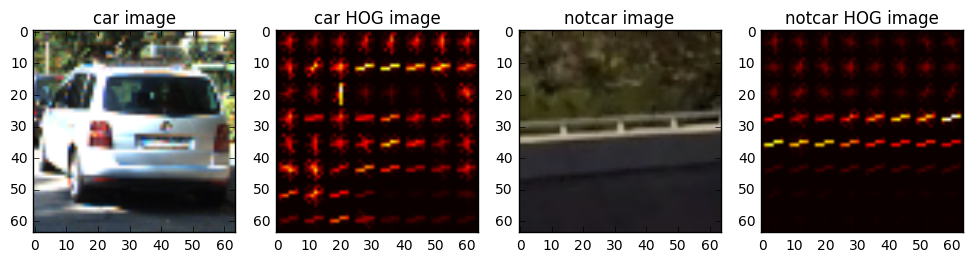

In [72]:
%matplotlib inline

# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space = color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                 vis = True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space = color_space, 
                                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                                        orient=orient, pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                        spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                        hog_feat=hog_feat, vis = True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize = (12, 3))
visualize(fig, 1, 4, images, titles)
directory = './output_images/'


### Training the Linear Support Vector Classifier

In [73]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimenstions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 2100
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]#cars
test_notcars = np.array(notcars)[random_idxs] #notcars

car_features = extract_features(test_cars, color_space = color_space, spatial_size = spatial_size, hist_bins = hist_bins,
                               orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                               hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat, 
                               hog_feat = hog_feat)

notcar_features = extract_features(test_notcars, color_space = color_space, spatial_size = spatial_size, 
                                   hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, hog_channel = hog_channel, 
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

print('Using:', orient, 'orientations, ', pix_per_cell, ' pixels per cell, ', cell_per_block, ' cells per block, ',
     hist_bins, ' histogram bins, and', spatial_size, 'spatial sampling')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


81.06688094139099 Seconds to compute features...
Using: 9 orientations,  8  pixels per cell,  2  cells per block,  32  histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
41.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9952


### Drawing the bounding boxes on test images

0.0 1.0
2.4110379219055176 seconds to process one image searching 124 windows
0.0 1.0
0.9372539520263672 seconds to process one image searching 124 windows
0.0 1.0
0.8264679908752441 seconds to process one image searching 124 windows
0.0 1.0
0.7827877998352051 seconds to process one image searching 124 windows
0.0 1.0
0.8942971229553223 seconds to process one image searching 124 windows
0.0 1.0
0.9446189403533936 seconds to process one image searching 124 windows


True

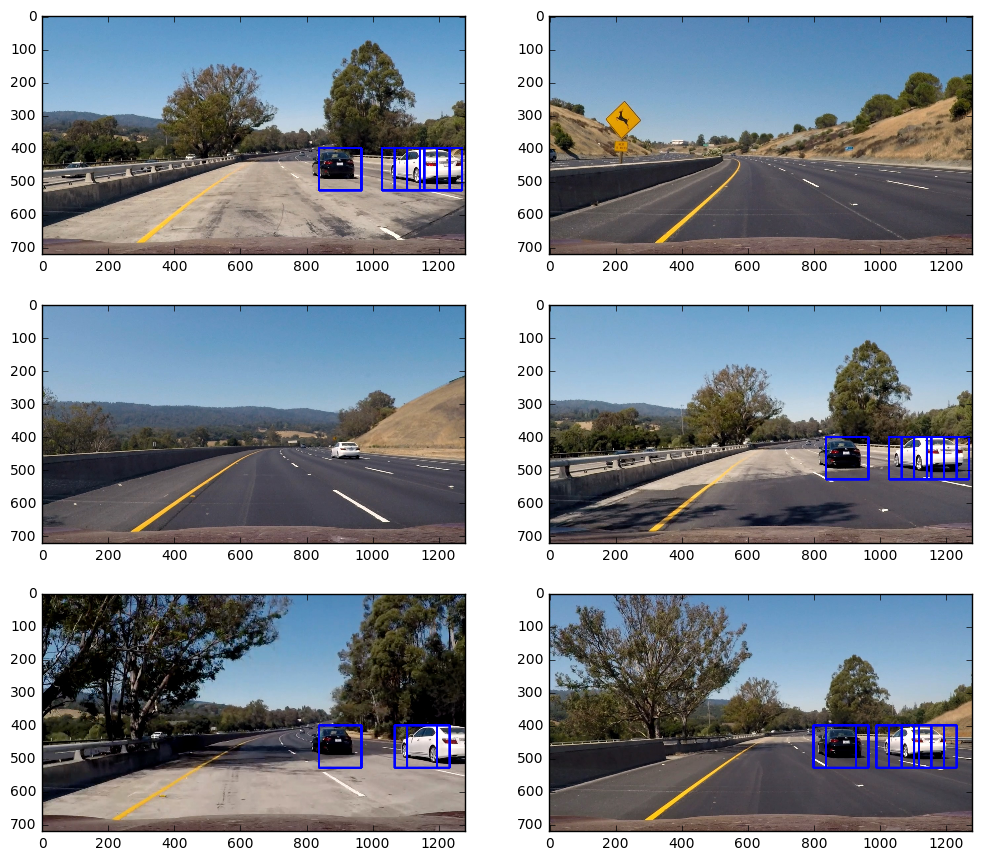

In [74]:
searchpath = './test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
overlap = 0.7
windows_for_images = []
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop, xy_window = (128, 128),
                          xy_overlap = (overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space, spatial_size = spatial_size,
                                hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell, cell_per_block = 
                                cell_per_block, hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = 
                                hist_feat, hog_feat = hog_feat)
    windows_for_images.append(windows)
    window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    images.append(window_img)
    titles.append(' ')
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize = (12, 18), dpi = 300)
visualize(fig, 5, 2, images, titles)

slide_image = mpimg.imread('./test_images/test1.jpg')
slide_image = slide_image.astype(np.float32) / 255
windows = slide_window(slide_image, x_start_stop = [None, None], y_start_stop = y_start_stop, xy_window = (128, 128),
                          xy_overlap = (overlap, overlap))
window_img = draw_boxes(slide_image, windows, color=(0, 0, 255), thick=6)
cv2.imwrite('./output_images/slide_window.jpg', window_img)

In [75]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Building the heatmap to combine overlapping detections and remove false positives

0.9910781383514404 seconds to run, total windows =  294
0.574638843536377 seconds to run, total windows =  294
0.6385288238525391 seconds to run, total windows =  294
0.6010129451751709 seconds to run, total windows =  294
0.5592210292816162 seconds to run, total windows =  294
0.5476460456848145 seconds to run, total windows =  294


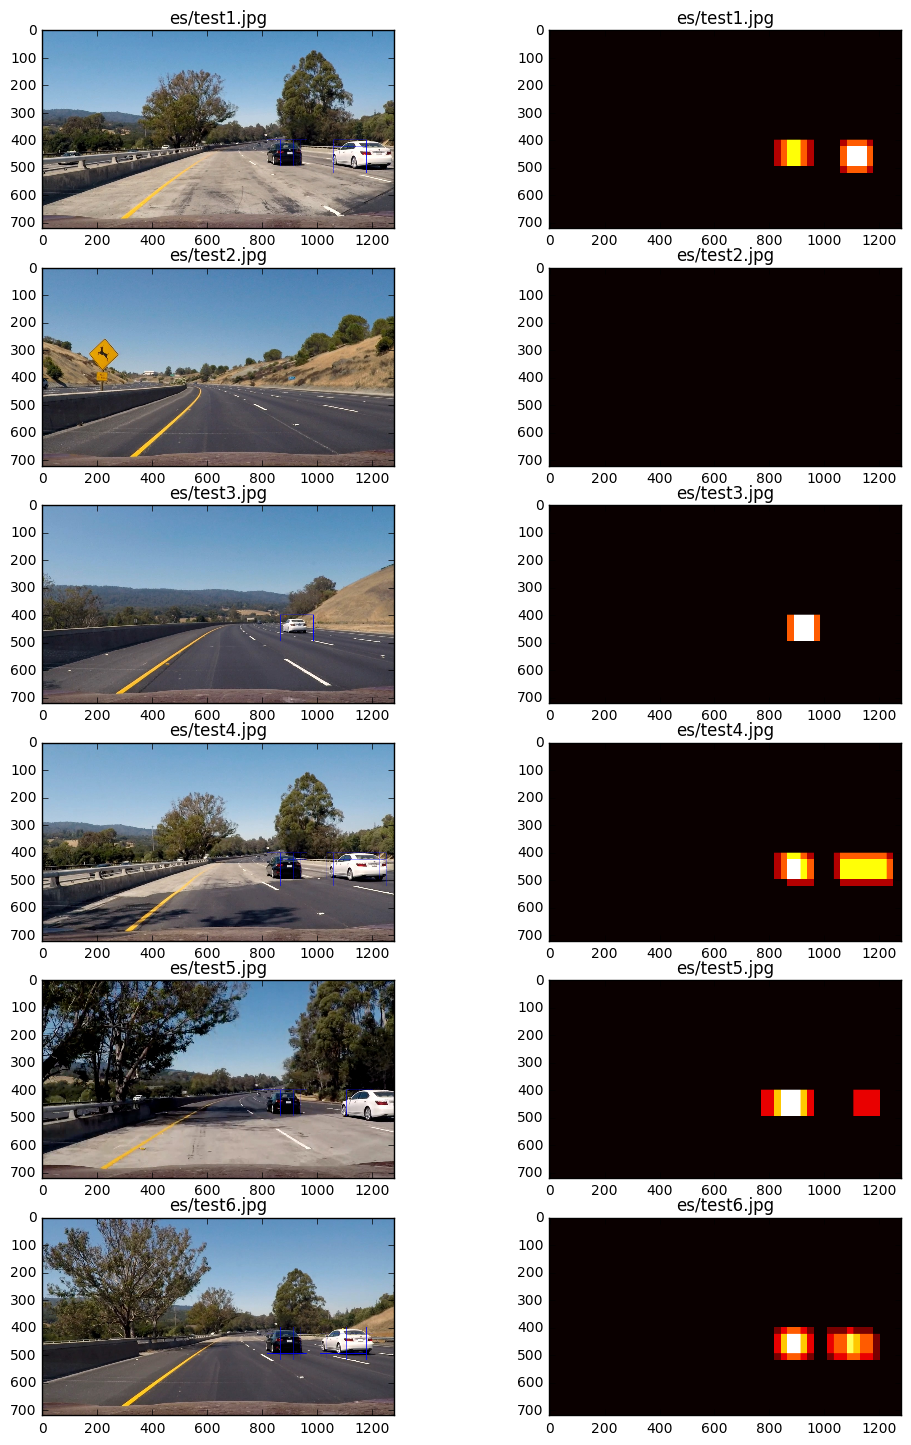

In [76]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart), 
                              (0, 0, 255))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
    
    print(time.time() - t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    #heatmap = 255 * heatmap / np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize = (12, 24))
visualize(fig, 8, 2, out_images, out_titles)

        

### Gather all of the above steps to write the pipeline function

In [77]:
# Iterate over test images
def find_cars(img, scale):
    img_boxes = []
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart), 
                              (0, 0, 255))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                #heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
    
    return draw_img, img_boxes
    

In [78]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [79]:
example_image = mpimg.imread('./test_images/test1.jpg')

store_boxes = []

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def process_image(img):
    global store_boxes
    
    out_img, img_boxes = find_cars(img, scale)
    
    store_boxes.append(img_boxes)
    store_boxes = store_boxes[-25:]
    
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    
    heat_map = add_heat(heat_map, [bbox for bboxes in store_boxes for bbox in bboxes])
    # Apply threshold to the heatmap
    heat_map = apply_threshold(heat_map, 15)
    
    # Visualize the heatmap when displaying    
    vis_heat = np.clip(heat_map, 0, 255)

    labels = label(vis_heat)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio = False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [10:39<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



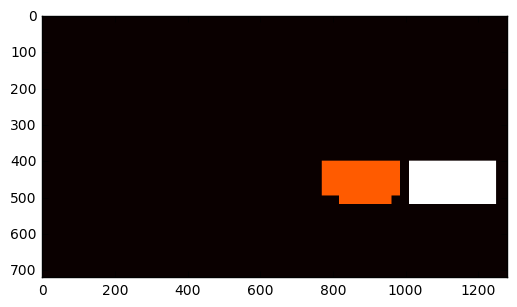

In [81]:
out_images = []
heat_maps = []
labeled_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    draw_img, bboxes = find_cars(img, scale)
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    show_boxes = draw_boxes(draw_img, bboxes, color=(0, 0, 255), thick=6)
    out_images.append(show_boxes)
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map = add_heat(heat_map, bboxes)
    heatmap = np.clip(heat_map, 0, 255)
    heat_maps.append(heatmap)
    labels = label(heatmap)
    labeled_img = draw_labeled_bboxes(np.copy(img), labels)
    labeled_images.append(labeled_img)

for i,image in enumerate(out_images):
    plt.imsave('./output_images/pipeline_before_heat' + str(i + 1) +'.jpg', image)
    
for i,image in enumerate(heat_maps):
    plt.imsave('./output_images/heat_applied' + str(i + 1) +'.jpg', image, cmap = 'hot')
    
for i,image in enumerate(labeled_images):
    plt.imsave('./output_images/labeled' + str(i + 1) +'.jpg', image)
    

heat_sum = np.zeros_like(heat_maps[0])
for heat in heat_maps:
    heat_sum += heat
    
integrated_heat = np.clip(heat_sum, 0, 255)
labeled_heat_sum = label(integrated_heat)
plt.imshow(labeled_heat_sum[0], cmap = 'hot')
plt.imsave('./output_images/integrated_heat.jpg', labeled_heat_sum[0], cmap = 'hot')



    

